In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import os

# Phase 1: Identify Repetitive Activities

This notebook analyzes the application log data to identify repetitive activities suitable for automation using a **three-dimensional framework**:

1. **Frequency Analysis**: Activities with >1000 occurrences (high-volume candidates)
2. **Temporal Variance Analysis**: IQR/Median ratio (process predictability - lower = more automation-ready)

3. **Resource Concentration Analysis**: Gini coefficient and resource distribution (standardization level)The framework uses **Relative IQR (IQR/Median)** instead of CV for temporal variance as it is more robust to outliers and provides better discrimination between automation-ready activities (low variability) and complex decision-intensive activities (high variability).


In [2]:
# Load the cleaned CSV file
df = pd.read_csv('application_log_clean_timestamp.csv')

# Convert timestamp to datetime (using ISO8601 format)
df['Start_Time'] = pd.to_datetime(df['Start_Time'], format='ISO8601')
df['End_Time'] = pd.to_datetime(df['End_Time'], format='ISO8601')

# Filter out already automated activities
# These activities are already automated according to domain knowledge:
# - W_Handle leads: Already automated (unless technical errors)
# - A_Submitted: Performed by User_1 (system) according to academic research
# - A_Concept: Automatic assessment
already_automated_activities = ['W_Handle leads', 'A_Submitted', 'A_Concept']

# Filter out already automated resource
# User_1 is an automated system resource
already_automated_resources = ['User_1']

print(f"Original dataset shape: {df.shape}")

# Remove already automated activities
print(f"\nRemoving already automated activities: {already_automated_activities}")
removed_activity_counts = df[df['activity'].isin(already_automated_activities)]['activity'].value_counts()
print(f"Events removed by activity:")
for activity, count in removed_activity_counts.items():
    print(f"  - {activity}: {count:,} events")
df = df[~df['activity'].isin(already_automated_activities)].copy()

# Remove already automated resources
print(f"\nRemoving already automated resources: {already_automated_resources}")
removed_resource_counts = df[df['resource'].isin(already_automated_resources)]['resource'].value_counts()
print(f"Events removed by resource:")
for resource, count in removed_resource_counts.items():
    print(f"  - {resource}: {count:,} events")
df = df[~df['resource'].isin(already_automated_resources)].copy()

print(f"\nFiltered dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Original dataset shape: (1202267, 20)

Removing already automated activities: ['W_Handle leads', 'A_Submitted', 'A_Concept']
Events removed by activity:
  - W_Handle leads: 47,264 events
  - A_Concept: 31,509 events
  - A_Submitted: 20,423 events

Removing already automated resources: ['User_1']
Events removed by resource:
  - User_1: 73,531 events

Filtered dataset shape: (1029540, 20)

Column names: ['Action', 'resource', 'activity', 'EventOrigin', 'EventID', 'lifecycle_transition', 'case_LoanGoal', 'case_ApplicationType', 'case_id', 'case_RequestedAmount', 'FirstWithdrawalAmount', 'NumberOfTerms', 'Accepted', 'MonthlyCost', 'Selected', 'CreditScore', 'OfferedAmount', 'OfferID', 'End_Time', 'Start_Time']

First few rows:


,Action,resource,activity,EventOrigin,EventID,lifecycle_transition,case_LoanGoal,case_ApplicationType,case_id,case_RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,End_Time,Start_Time
6,Obtained,User_17,W_Complete application,Workflow,Workitem_1875340971,start,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-02 11:45:22.429,2016-01-02 11:40:21.315
7,Released,User_17,W_Complete application,Workflow,Workitem_1452291795,suspend,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-02 11:49:28.816,2016-01-02 11:45:22.429
8,statechange,User_52,A_Accepted,Application,ApplState_99568828,complete,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-02 12:23:04.299,2016-01-02 12:23:04.299
9,Created,User_52,O_Create Offer,Offer,Offer_148581083,complete,Existing loan takeover,New credit,Application_652823628,20000.0,20000.0,44.0,True,498.29,True,979.0,20000.0,NaN,2016-01-02 12:29:03.994,2016-01-02 12:23:04.299
10,statechange,User_52,O_Created,Offer,OfferState_1514834199,complete,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_148581083,2016-01-02 12:29:05.354,2016-01-02 12:29:03.994


## 1. Frequency Analysis
Count occurrences per activity and filter those with >1000 occurrences.

In [3]:
# Count occurrences per activity across all cases
activity_frequency = df['activity'].value_counts().reset_index()
activity_frequency.columns = ['Activity', 'Frequency']

print(f"Total number of unique activities: {len(activity_frequency)}")
print(f"\nAll activities with their frequencies:")
print(activity_frequency.to_string())

# Filter activities with >1000 occurrences
high_freq_activities = activity_frequency[activity_frequency['Frequency'] > 1000].copy()

print(f"\n{'='*60}")
print(f"Activities with >1000 occurrences: {len(high_freq_activities)}")
print(f"{'='*60}")
print(high_freq_activities.to_string())

Total number of unique activities: 23

All activities with their frequencies:
                      Activity  Frequency
0       W_Validate application     208268
1          W_Call after offers     175270
2      W_Call incomplete files     167843
3       W_Complete application     131780
4               O_Create Offer      42995
5                    O_Created      42995
6     O_Sent (mail and online)      39707
7                 A_Validating      38816
8                   A_Accepted      31509
9                   A_Complete      31362
10                  O_Returned      23305
11                A_Incomplete      23055
12                  O_Accepted      17228
13                   A_Pending      17228
14        A_Create Application      11086
15                 O_Cancelled      10916
16                   O_Refused       4695
17                    A_Denied       3753
18    W_Assess potential fraud       2965
19                 A_Cancelled       2478
20        O_Sent (online only)       202

## 2. Temporal Variance Analysis (IQR-Based)


Calculate **Relative IQR (IQR/Median)** as the primary temporal variance metric for the framework. This metric is:We also calculate CV and percentile ranges for comparison and additional insights.

- **Robust to outliers**: Uses quartiles instead of mean/std

- **Normalized**: Comparable across activities with different time scales- **Discriminative**: Better separates automation-ready (low IQR/Median) from complex activities (high IQR/Median)

In [4]:
df_sorted = df.sort_values(['case_id', 'Start_Time']).copy()

# Calculate duration for each activity (time between consecutive events in a case)
# This will show how long each activity takes
df_sorted['next_timestamp'] = df_sorted.groupby('case_id')['Start_Time'].shift(-1)
df_sorted['duration_seconds'] = (df_sorted['next_timestamp'] - df_sorted['Start_Time']).dt.total_seconds()

# Remove negative durations and NaN values
df_with_duration = df_sorted[df_sorted['duration_seconds'] > 0].copy()

# Calculate comprehensive statistics for each activity including robust metrics
def calculate_percentiles(x):
    return pd.Series({
        'Q1': x.quantile(0.25),
        'Q3': x.quantile(0.75),
        'P10': x.quantile(0.10),
        'P90': x.quantile(0.90)
    })

# Basic statistics
temporal_stats = df_with_duration.groupby('activity')['duration_seconds'].agg([
    'count',
    'mean',
    'median',
    'std'
]).reset_index()

# Percentile statistics
percentile_stats = df_with_duration.groupby('activity')['duration_seconds'].apply(calculate_percentiles).reset_index()
percentile_stats_wide = percentile_stats.pivot(index='activity', columns='level_1', values='duration_seconds').reset_index()

# Merge all statistics
temporal_stats = temporal_stats.merge(percentile_stats_wide, on='activity', how='left')

# Rename columns correctly - pivot creates columns in alphabetical order: P10, P90, Q1, Q3
temporal_stats.columns = ['Activity', 'Count', 'Mean_Duration_Sec', 'Median_Duration_Sec', 'Std_Duration_Sec',
                          'P10_Sec', 'P90_Sec', 'Q1_Sec', 'Q3_Sec']

# Calculate coefficient of variation (CV = std / mean)
temporal_stats['CV'] = temporal_stats['Std_Duration_Sec'] / temporal_stats['Mean_Duration_Sec']

# Calculate Interquartile Range (IQR) - more robust to outliers
temporal_stats['IQR_Sec'] = temporal_stats['Q3_Sec'] - temporal_stats['Q1_Sec']

# Calculate normalized IQR (relative IQR = IQR / median) - comparable across activities
temporal_stats['Relative_IQR'] = temporal_stats['IQR_Sec'] / temporal_stats['Median_Duration_Sec']

# Calculate percentile range (P90 - P10) for additional robustness
temporal_stats['P90_P10_Range_Sec'] = temporal_stats['P90_Sec'] - temporal_stats['P10_Sec']
temporal_stats['Relative_P90_P10'] = temporal_stats['P90_P10_Range_Sec'] / temporal_stats['Median_Duration_Sec']

# Add duration in more readable formats
temporal_stats['Mean_Duration_Hours'] = temporal_stats['Mean_Duration_Sec'] / 3600
temporal_stats['Median_Duration_Hours'] = temporal_stats['Median_Duration_Sec'] / 3600
temporal_stats['IQR_Hours'] = temporal_stats['IQR_Sec'] / 3600

# Filter for activities with >1000 occurrences
temporal_stats_filtered = temporal_stats[temporal_stats['Count'] > 1000].copy()

# Sort by Relative IQR to identify stable activities (lower = more predictable)
temporal_stats_sorted = temporal_stats_filtered.sort_values('Relative_IQR')

print("Temporal Variance Analysis for Activities (>1000 occurrences)")
print("="*120)
print("\n🎯 PRIMARY METRIC: Relative IQR (IQR/Median)")
print("   - Framework Dimension 2: Process Predictability")
print("   - Lower values = More automation-ready (consistent execution times)")
print("   - Higher values = Complex/decision-intensive (variable execution times)")
print("\n" + "="*120)
print(temporal_stats_sorted[['Activity', 'Count', 'Median_Duration_Hours', 
                             'Relative_IQR', 'IQR_Hours', 'Relative_P90_P10']].to_string())

# Identify activities with low relative IQR (< 1.0 = IQR smaller than median duration)
low_iqr_activities = temporal_stats_sorted[temporal_stats_sorted['Relative_IQR'] < 1.0].copy()

print(f"\n{'='*120}")
print(f"🎯 FRAMEWORK DIMENSION 2 RESULTS: Activities with LOW RELATIVE IQR (< 1.0)")
print(f"   Interpretation: High automation potential due to predictable, consistent execution times")
print(f"   Count: {len(low_iqr_activities)} activities")
print(f"{'='*120}")
if len(low_iqr_activities) > 0:
    print(low_iqr_activities[['Activity', 'Count', 'Median_Duration_Hours', 'Relative_IQR', 
                               'IQR_Hours']].to_string())
else:
    print("No activities found with Relative IQR < 1.0")


Temporal Variance Analysis for Activities (>1000 occurrences)

🎯 PRIMARY METRIC: Relative IQR (IQR/Median)
   - Framework Dimension 2: Process Predictability
   - Lower values = More automation-ready (consistent execution times)
   - Higher values = Complex/decision-intensive (variable execution times)

                    Activity   Count  Median_Duration_Hours  Relative_IQR     IQR_Hours  Relative_P90_P10
2                 A_Complete   31350           5.555556e-07      0.500000  2.777778e-07          2.000000
5               A_Incomplete   23055           5.555556e-07      0.500000  2.777778e-07          2.000000
11                 O_Created   42974           3.002778e-04      0.706753  2.122222e-04          0.960222
6                  A_Pending   17228           1.111111e-06      0.750000  8.333333e-07          2.500000
12                 O_Refused    4695           8.333333e-06      0.766667  6.388889e-06          2.000000
7               A_Validating   38816           2.061111e-04

## 3. Resource Pattern Analysis
Analyze resource distribution per activity to identify activities performed by single/few resources (potentially already automated).

In [5]:
# Analyze resource distribution per activity
# Focus on W_* activities with >1000 occurrences

# Get unique resource count per activity
resource_analysis = df.groupby('activity').agg({
    'resource': ['nunique', 'count'],
    'case_id': 'nunique'
}).reset_index()

resource_analysis.columns = ['Activity', 'Unique_Resources', 'Total_Events', 'Unique_Cases']

# Calculate resource concentration ratio (events per resource)
resource_analysis['Events_Per_Resource'] = resource_analysis['Total_Events'] / resource_analysis['Unique_Resources']

# Filter for activities with >1000 occurrences
resource_analysis_filtered = resource_analysis[resource_analysis['Total_Events'] > 1000].copy()

# Sort by unique resources (ascending) to find activities with few resources
resource_analysis_sorted = resource_analysis_filtered.sort_values('Unique_Resources')

print("Resource Pattern Analysis for Activities (>1000 occurrences)")
print("="*100)
print(resource_analysis_sorted.to_string())

# Identify activities with very few resources (potentially automated)
# Let's consider activities with <= 5 unique resources as potentially automated
few_resource_activities = resource_analysis_sorted[resource_analysis_sorted['Unique_Resources'] <= 5].copy()

print(f"\n{'='*100}")
print(f"Activities with FEW RESOURCES (<=5) - Potentially Already Automated: {len(few_resource_activities)}")
print(f"{'='*100}")
if len(few_resource_activities) > 0:
    print(few_resource_activities.to_string())
else:
    print("No activities found with <=5 unique resources")

Resource Pattern Analysis for Activities (>1000 occurrences)
                    Activity  Unique_Resources  Total_Events  Unique_Cases  Events_Per_Resource
6                  A_Pending                40         17228         17228           430.700000
8                 O_Accepted                40         17228         17228           430.700000
13                O_Returned                47         23305         21768           495.851064
16  W_Assess potential fraud                55          2965           303            53.909091
12                 O_Refused                97          4695          3720            48.402062
4                   A_Denied                99          3753          3752            37.909091
5               A_Incomplete               101         23055         15003           228.267327
15      O_Sent (online only)               104          2026          1800            19.480769
1                A_Cancelled               107          2478          2478 

In [6]:
# Additional detailed resource analysis - show specific resources per activity
print("\nDetailed Resource Distribution for Each Activity:")
print("="*100)

# Function to calculate Gini coefficient
def gini_coefficient(counts):
    """Calculate Gini coefficient for resource distribution"""
    sorted_counts = np.sort(counts)
    n = len(counts)
    cumsum = np.cumsum(sorted_counts)
    return (2 * np.sum((np.arange(1, n + 1)) * sorted_counts)) / (n * cumsum[-1]) - (n + 1) / n

# Enhanced resource analysis for each activity
resource_concentration_details = []

for activity in resource_analysis_sorted['Activity'].values:
    activity_resources = df[df['activity'] == activity]['resource'].value_counts()
    total_events = activity_resources.sum()
    n_resources = len(activity_resources)
    
    # Calculate top resource percentages
    top_1_pct = (activity_resources.iloc[0] / total_events * 100) if len(activity_resources) > 0 else 0
    top_3_pct = (activity_resources.head(3).sum() / total_events * 100) if len(activity_resources) >= 3 else top_1_pct
    
    # Calculate Gini coefficient
    gini = gini_coefficient(activity_resources.values)
    
    resource_concentration_details.append({
        'Activity': activity,
        'N_Resources': n_resources,
        'Top_1_Resource_Pct': top_1_pct,
        'Top_3_Resources_Pct': top_3_pct,
        'Gini_Coefficient': gini,
        'Top_Resource': activity_resources.index[0] if len(activity_resources) > 0 else 'N/A'
    })
    
    print(f"\n{activity}:")
    print(f"  Total unique resources: {n_resources}")
    print(f"  Top resource ({activity_resources.index[0]}): {activity_resources.iloc[0]:,} events ({top_1_pct:.1f}%)")
    print(f"  Top 3 resources: {top_3_pct:.1f}% of all events")
    print(f"  Gini coefficient: {gini:.3f} (0=equal distribution, 1=concentrated)")
    print(f"  Top 10 resources:")
    for idx, (resource, count) in enumerate(activity_resources.head(10).items(), 1):
        pct = count / total_events * 100
        print(f"    {idx}. {resource}: {count:,} ({pct:.1f}%)")

# Create DataFrame with concentration metrics
concentration_df = pd.DataFrame(resource_concentration_details)

print("\n" + "="*120)
print("RESOURCE CONCENTRATION SUMMARY")
print("="*120)
print(concentration_df.to_string(index=False))


Detailed Resource Distribution for Each Activity:

A_Pending:
  Total unique resources: 40
  Top resource (User_29): 1,710 events (9.9%)
  Top 3 resources: 23.8% of all events
  Gini coefficient: 0.508 (0=equal distribution, 1=concentrated)
  Top 10 resources:
    1. User_29: 1,710 (9.9%)
    2. User_109: 1,235 (7.2%)
    3. User_90: 1,147 (6.7%)
    4. User_75: 1,036 (6.0%)
    5. User_68: 971 (5.6%)
    6. User_30: 970 (5.6%)
    7. User_102: 943 (5.5%)
    8. User_100: 914 (5.3%)
    9. User_118: 766 (4.4%)
    10. User_87: 749 (4.3%)

O_Accepted:
  Total unique resources: 40
  Top resource (User_29): 1,710 events (9.9%)
  Top 3 resources: 23.8% of all events
  Gini coefficient: 0.508 (0=equal distribution, 1=concentrated)
  Top 10 resources:
    1. User_29: 1,710 (9.9%)
    2. User_109: 1,235 (7.2%)
    3. User_90: 1,147 (6.7%)
    4. User_75: 1,036 (6.0%)
    5. User_68: 971 (5.6%)
    6. User_30: 970 (5.6%)
    7. User_102: 943 (5.5%)
    8. User_100: 914 (5.3%)
    9. User_118:

## Summary: Three-Dimensional Automation Framework

Combine all three analytical dimensions to create a comprehensive view of automation candidates:

Activities scoring favorably across all three dimensions are optimal automation candidates.

**Framework Dimensions:**

1. 📊 **Frequency** (Dimension 1): Volume-based ROI indicator (>1000 occurrences)
2. ⏱️ **Temporal Variance** (Dimension 2): **Relative IQR (IQR/Median)** - Process predictability
3. 👥 **Resource Concentration** (Dimension 3): Gini coefficient - Standardization level

In [7]:
# Create comprehensive summary combining all three analyses
summary_df = resource_analysis_sorted.merge(
    temporal_stats_sorted[['Activity', 'Mean_Duration_Hours', 'Median_Duration_Hours', 'CV', 
                           'Relative_IQR', 'IQR_Hours', 'Relative_P90_P10']], 
    on='Activity', 
    how='left'
)

# Merge with frequency data
summary_df = summary_df.merge(
    high_freq_activities[['Activity', 'Frequency']], 
    on='Activity', 
    how='left'
)

# Merge with resource concentration metrics
summary_df = summary_df.merge(
    concentration_df[['Activity', 'Top_1_Resource_Pct', 'Top_3_Resources_Pct', 'Gini_Coefficient']], 
    on='Activity', 
    how='left'
)

# Reorder columns for better readability
summary_df = summary_df[['Activity', 'Frequency', 'Unique_Resources', 'Events_Per_Resource', 
                         'Top_1_Resource_Pct', 'Top_3_Resources_Pct', 'Gini_Coefficient',
                         'Mean_Duration_Hours', 'Median_Duration_Hours', 'CV', 
                         'Relative_IQR', 'IQR_Hours', 'Relative_P90_P10']]

# Sort by frequency (descending) to prioritize most common activities
summary_df = summary_df.sort_values('Frequency', ascending=False)

print("COMPREHENSIVE AUTOMATION CANDIDATE ANALYSIS")
print("="*120)
print("\nAll Activities with >1000 occurrences:")
print(summary_df[['Activity', 'Frequency', 'Unique_Resources', 'Median_Duration_Hours', 
                  'Relative_IQR', 'Gini_Coefficient']].to_string(index=False))

print("\n" + "="*120)
print("🎯 THREE-DIMENSIONAL AUTOMATION FRAMEWORK: KEY FINDINGS")
print("="*120)
print(f"""
📊 DIMENSION 1: FREQUENCY ANALYSIS (Volume-Based ROI)
   - {len(high_freq_activities)} activities have >1000 occurrences
   - Most frequent: {summary_df.iloc[0]['Activity']} ({int(summary_df.iloc[0]['Frequency']):,} occurrences)
   - Interpretation: Higher frequency = Greater automation ROI

⏱️ DIMENSION 2: TEMPORAL VARIANCE (Process Predictability via Relative IQR)
   - Activities with low Relative IQR (< 1.0): {len(low_iqr_activities)}
   - Most predictable: {temporal_stats_sorted.iloc[0]['Activity']} (Relative IQR = {temporal_stats_sorted.iloc[0]['Relative_IQR']:.2f})
   - Interpretation: Lower Relative IQR = More automation-ready (consistent execution times)

👥 DIMENSION 3: RESOURCE CONCENTRATION (Standardization Level)
   - Most concentrated: {resource_analysis_sorted.iloc[0]['Activity']} ({int(resource_analysis_sorted.iloc[0]['Unique_Resources'])} resources, {int(resource_analysis_sorted.iloc[0]['Events_Per_Resource'])} events/resource)
   - Activities with >80% single resource: {len(concentration_df[concentration_df['Top_1_Resource_Pct'] > 80])}
   - Highest Gini: {concentration_df.loc[concentration_df['Gini_Coefficient'].idxmax(), 'Activity']} ({concentration_df['Gini_Coefficient'].max():.3f})
   - Interpretation: Higher concentration = More standardized, easier to automate

🔍 TOP 3 ACTIVITIES BY FREQUENCY (Framework Dimension 1):
""")

for idx, row in summary_df.head(3).iterrows():
    print(f"      - 📊 Frequency (Dim 1): {int(row['Frequency']):,} occurrences")
    print(f"      - ⏱️ Temporal Variance (Dim 2): Relative IQR = {row['Relative_IQR']:.2f}")
    print(f"      - 👥 Resource Concentration (Dim 3): Gini = {row['Gini_Coefficient']:.3f}, Top resource = {row['Top_1_Resource_Pct']:.1f}%")
    print(f"      - Framework Assessment: {'✅ High automation potential' if row['Relative_IQR'] < 1.0 and row['Gini_Coefficient'] > 0.5 else '🔍 Requires further evaluation'}")
    print()


COMPREHENSIVE AUTOMATION CANDIDATE ANALYSIS

All Activities with >1000 occurrences:
                Activity  Frequency  Unique_Resources  Median_Duration_Hours  Relative_IQR  Gini_Coefficient
  W_Validate application     208268               132           6.621389e-03    108.997819          0.763379
     W_Call after offers     175270               143           2.773056e-03  17669.328058          0.581052
 W_Call incomplete files     167843               137           2.395000e-02     66.555509          0.611623
  W_Complete application     131780               124           2.713472e-03     92.615217          0.546265
               O_Created      42995               120           3.002778e-04      0.706753          0.548505
          O_Create Offer      42995               120           5.121056e-02      1.346897          0.548505
O_Sent (mail and online)      39707               114           7.920972e-03      3.405595          0.529294
            A_Validating      38816         

## Next Steps: Advanced Automation Impact Analysis

In [8]:
### STEP 1: Classify Activities by Automation Potential

# Define activity categories based on your domain knowledge
# Note: already_automated activities have been filtered out of the dataset
high_automation_potential = [
    'O_Sent (mail and online)', 'O_Sent (online only)', 
    'O_Create Offer', 'O_Created',
    'W_Validate application', 'A_Incomplete',
    'W_Assess potential fraud'
]
requires_human_action = ['W_Call after offers', 'W_Call incomplete files']  # Human-performed actions
requires_human_judgment = ['A_Denied', 'A_Cancelled']  # Actions requiring human judgment
to_be_evaluated = [
    'A_Accepted', 'A_Pending', 'A_Approved', 'A_Declined', 'A_Registered',
    'W_Complete application',
    'O_Returned', 'O_Accepted', 'O_Cancelled', 'O_Declined'
]

# Add classification to dataframe
def classify_activity(activity):
    if activity in high_automation_potential:
        return 'High Automation Potential'
    elif activity in requires_human_action:
        return 'Requires Human Action'
    elif activity in requires_human_judgment:
        return 'Requires Human Judgment'
    elif activity in to_be_evaluated:
        return 'To Be Evaluated'
    else:
        return 'Other'

summary_df['Automation_Category'] = summary_df['Activity'].apply(classify_activity)

# Display classified summary
print("ACTIVITY CLASSIFICATION BY AUTOMATION POTENTIAL")
print("\nNote: Already automated activities (W_Handle leads, A_Submitted, A_Concept) have been excluded from analysis.\n")

for category in ['High Automation Potential', 'Requires Human Action', 'Requires Human Judgment', 'To Be Evaluated', 'Other']:
    activities = summary_df[summary_df['Automation_Category'] == category]
    total_events = activities['Frequency'].sum()
    
    print(f"\n{category.upper()}: {len(activities)} activities, {total_events:,} total events")
    print("-" * 100)
    
    if len(activities) > 0:
        for idx, row in activities.iterrows():
            print(f"  • {row['Activity']:40s} | Freq: {int(row['Frequency']):>8,} | Rel.IQR: {row['Relative_IQR']:>8.2f} | Gini: {row['Gini_Coefficient']:.3f}")
        
        # Calculate aggregate statistics for the category
        avg_rel_iqr = activities['Relative_IQR'].mean()
        avg_gini = activities['Gini_Coefficient'].mean()
        print(f"\n  Category Averages: Relative IQR = {avg_rel_iqr:.2f}, Gini = {avg_gini:.3f}")

print("\n" + "="*120)
print("FRAMEWORK INSIGHTS:")
print("="*120)
print(f"""
✅ HIGH AUTOMATION POTENTIAL ({len(summary_df[summary_df['Automation_Category'] == 'High Automation Potential'])} activities):
   - Rule-based, repetitive tasks ideal for full automation
   - High ROI due to frequency and standardization

📞 REQUIRES HUMAN ACTION ({len(summary_df[summary_df['Automation_Category'] == 'Requires Human Action'])} activities):
   - Activities inherently requiring human interaction (e.g., calls)
   - Cannot be fully automated but may benefit from better tooling/scripting

⚠️  REQUIRES HUMAN JUDGMENT ({len(summary_df[summary_df['Automation_Category'] == 'Requires Human Judgment'])} activities):
   - Complex decisions requiring human expertise and judgment
   - May benefit from decision support tools rather than full automation

🔍 TO BE EVALUATED ({len(summary_df[summary_df['Automation_Category'] == 'To Be Evaluated'])} activities):
   - Require deeper analysis to determine automation feasibility
   - Consider: regulatory constraints, data availability, business rules complexity
""")

ACTIVITY CLASSIFICATION BY AUTOMATION POTENTIAL

Note: Already automated activities (W_Handle leads, A_Submitted, A_Concept) have been excluded from analysis.


HIGH AUTOMATION POTENTIAL: 7 activities, 362,011 total events
----------------------------------------------------------------------------------------------------
  • W_Validate application                   | Freq:  208,268 | Rel.IQR:   109.00 | Gini: 0.763
  • O_Created                                | Freq:   42,995 | Rel.IQR:     0.71 | Gini: 0.549
  • O_Create Offer                           | Freq:   42,995 | Rel.IQR:     1.35 | Gini: 0.549
  • O_Sent (mail and online)                 | Freq:   39,707 | Rel.IQR:     3.41 | Gini: 0.529
  • A_Incomplete                             | Freq:   23,055 | Rel.IQR:     0.50 | Gini: 0.811
  • W_Assess potential fraud                 | Freq:    2,965 | Rel.IQR:    20.75 | Gini: 0.735
  • O_Sent (online only)                     | Freq:    2,026 | Rel.IQR:  1073.09 | Gini: 0.551

  C

In [9]:
### STEP 4: Automation Feasibility Matrix (Three-Dimensional Framework Integration)

print("🎯 AUTOMATION FEASIBILITY MATRIX - Three-Dimensional Framework")
print("="*120)
print("\nFramework Integration:")
print("  - Dimension 1 (Frequency): 30% weight - Volume-based ROI")
print("  - Dimension 2 (Temporal Variance via Relative IQR): 20% weight - Process predictability")
print("  - Dimension 3 (Resource Concentration via Gini): 15% weight - Standardization level")
print("  - Domain Knowledge: 35% weight - Business context and strategic importance")
print("\nNote: Dimension 2 uses Relative IQR (not CV) for robust, outlier-resistant discrimination")
print("="*120)

# Create feasibility scores based on multiple factors
feasibility_df = summary_df[summary_df['Automation_Category'].isin(['High Automation Potential', 'To Be Evaluated'])].copy()

# Scoring criteria (0-10 scale) - Aligned with Three-Dimensional Framework:
# 1. Resource concentration (Dimension 3: higher Gini = easier to standardize) - 15% weight
feasibility_df['Resource_Score'] = (feasibility_df['Gini_Coefficient'] * 10).clip(0, 10)

# 2. Frequency (Dimension 1: higher frequency = higher ROI) - 30% weight
max_freq = feasibility_df['Frequency'].max()
feasibility_df['Frequency_Score'] = (feasibility_df['Frequency'] / max_freq * 10).clip(0, 10)

# 3. Process predictability (Dimension 2: using Relative IQR, lower = more predictable) - 20% weight
# Invert and normalize: lower Relative IQR gets higher scores
# This is the key framework improvement over CV-based approaches
max_rel_iqr = feasibility_df['Relative_IQR'].max()
min_rel_iqr = feasibility_df['Relative_IQR'].min()
feasibility_df['Predictability_Score'] = (
    ((max_rel_iqr - feasibility_df['Relative_IQR']) / (max_rel_iqr - min_rel_iqr) * 10).clip(0, 10)
)

# 4. Domain knowledge override
def get_domain_score(activity):
    """Manual scoring based on BPI 2017 winning papers' findings"""
    high_priority = {
        # Critical bottlenecks with high volume/impact
        'W_Validate application': 10,  # Both papers identify as major bottleneck
        'W_Call incomplete files': 9,   # Most time-consuming per professional winner
        
        # Communication activities - moderate impact
        'O_Sent (mail and online)': 7,  # Positive but not critical
        'O_Sent (online only)': 7,
        
        # Standard workflow - lower strategic value than expected
        'O_Create Offer': 6,            # ML shows low outcome correlation
        'O_Created': 6,
        
        # Status tracking - useful signal
        'A_Incomplete': 7,              # High frequency, improvement opportunity
        
        # Rare specialized activity
        'W_Assess potential fraud': 4   # <1% of cases, specialized
    }
    return high_priority.get(activity, 5) # Default, return medium priority


feasibility_df['Domain_Knowledge_Score'] = feasibility_df['Activity'].apply(get_domain_score)

# Calculate overall feasibility score (weighted average)
feasibility_df['Feasibility_Score'] = (
    feasibility_df['Resource_Score'] * 0.15 +
    feasibility_df['Frequency_Score'] * 0.30 +
    feasibility_df['Predictability_Score'] * 0.20 +
    feasibility_df['Domain_Knowledge_Score'] * 0.35
).round(2)

# Sort by feasibility score
feasibility_df = feasibility_df.sort_values('Feasibility_Score', ascending=False)

print("\n📈 Automation Feasibility Ranking (Framework-Based Scoring):")
print("   Predictability Score derived from Relative IQR (Dimension 2 of framework)")
print(feasibility_df[['Activity', 'Automation_Category', 'Frequency', 'Relative_IQR', 'Gini_Coefficient',
                      'Feasibility_Score', 'Predictability_Score']].to_string(index=False))

print("\n" + "="*120)
print("RECOMMENDED AUTOMATION ROADMAP (by priority):")
print("="*120)

top_5 = feasibility_df.head(5)
for idx, row in top_5.iterrows():
    rank = top_5.index.tolist().index(idx) + 1
    print(f"\n{rank}. {row['Activity']}")
    print(f"   ⭐ Overall Feasibility Score: {row['Feasibility_Score']:.1f}/10")
    print(f"   \n   Framework Dimension Scores:")
    print(f"     📊 Dimension 1 - Frequency: {int(row['Frequency']):,} occurrences (Score: {row['Frequency_Score']:.1f}/10)")
    print(f"     ⏱️ Dimension 2 - Temporal Variance: Relative IQR = {row['Relative_IQR']:.2f} (Predictability Score: {row['Predictability_Score']:.1f}/10)")
    print(f"     👥 Dimension 3 - Resource Concentration: Gini = {row['Gini_Coefficient']:.3f} (Score: {row['Resource_Score']:.1f}/10)")
    print(f"   Category: {row['Automation_Category']}")
    
    # Add specific recommendations
    if row['Activity'] == 'W_Validate application':
        print(f"   → Recommendation: Implement OCR + business rules for document validation")
    elif 'O_Sent' in row['Activity']:
        print(f"   → Recommendation: Fully automate communication triggers")
    elif 'O_Create' in row['Activity'] or 'O_Created' in row['Activity']:
        print(f"   → Recommendation: Rule-based automation (consider AI Act compliance)")
    elif row['Activity'] == 'W_Assess potential fraud':
        print(f"   → Recommendation: ML-based fraud detection model")

🎯 AUTOMATION FEASIBILITY MATRIX - Three-Dimensional Framework

Framework Integration:
  - Dimension 1 (Frequency): 30% weight - Volume-based ROI
  - Dimension 2 (Temporal Variance via Relative IQR): 20% weight - Process predictability
  - Dimension 3 (Resource Concentration via Gini): 15% weight - Standardization level
  - Domain Knowledge: 35% weight - Business context and strategic importance

Note: Dimension 2 uses Relative IQR (not CV) for robust, outlier-resistant discrimination

📈 Automation Feasibility Ranking (Framework-Based Scoring):
   Predictability Score derived from Relative IQR (Dimension 2 of framework)
                Activity       Automation_Category  Frequency  Relative_IQR  Gini_Coefficient  Feasibility_Score  Predictability_Score
  W_Validate application High Automation Potential     208268    108.997819          0.763379               9.44              8.988446
  W_Complete application           To Be Evaluated     131780     92.615217          0.546265          

## Visualization: Automation Impact Analysis

Visual representations to communicate automation opportunities and expected impact.

In [10]:
# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("Visualization libraries loaded successfully")

Visualization libraries loaded successfully


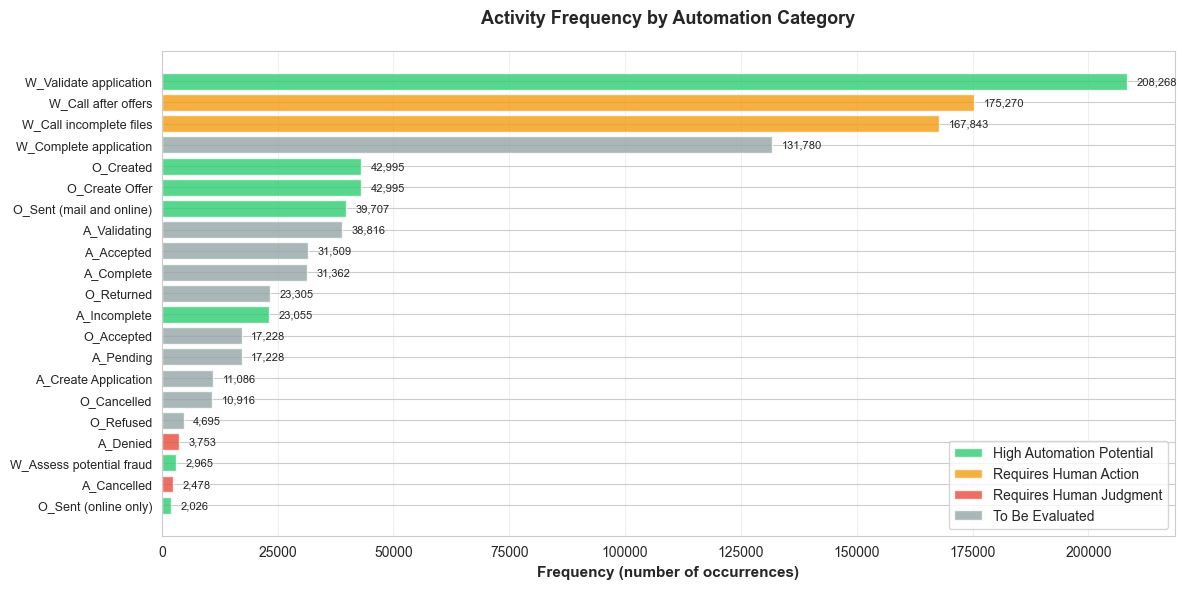


Total activities analyzed: 21


In [11]:
### PLOT 1: Activity Frequency Distribution by Automation Category

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Prepare data
category_colors = {
    'High Automation Potential': '#2ecc71',  # Green
    'Requires Human Action': '#f39c12',      # Orange
    'Requires Human Judgment': '#e74c3c',    # Red
    'To Be Evaluated': '#95a5a6'             # Gray
}

plot_data = summary_df.sort_values('Frequency', ascending=True)
colors = [category_colors.get(cat, '#95a5a6') for cat in plot_data['Automation_Category']]

# Create horizontal bar chart
bars = ax.barh(range(len(plot_data)), plot_data['Frequency'], color=colors, alpha=0.8)

# Customize
ax.set_yticks(range(len(plot_data)))
ax.set_yticklabels(plot_data['Activity'], fontsize=9)
ax.set_xlabel('Frequency (number of occurrences)', fontsize=11, fontweight='bold')
ax.set_title('Activity Frequency by Automation Category', fontsize=13, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (idx, row) in enumerate(plot_data.iterrows()):
    ax.text(row['Frequency'] + max(plot_data['Frequency'])*0.01, i, 
            f"{int(row['Frequency']):,}", 
            va='center', fontsize=8)

# Add legend
legend_elements = [Patch(facecolor=color, label=cat, alpha=0.8) 
                   for cat, color in category_colors.items() 
                   if cat in plot_data['Automation_Category'].values]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nTotal activities analyzed: {len(plot_data)}")

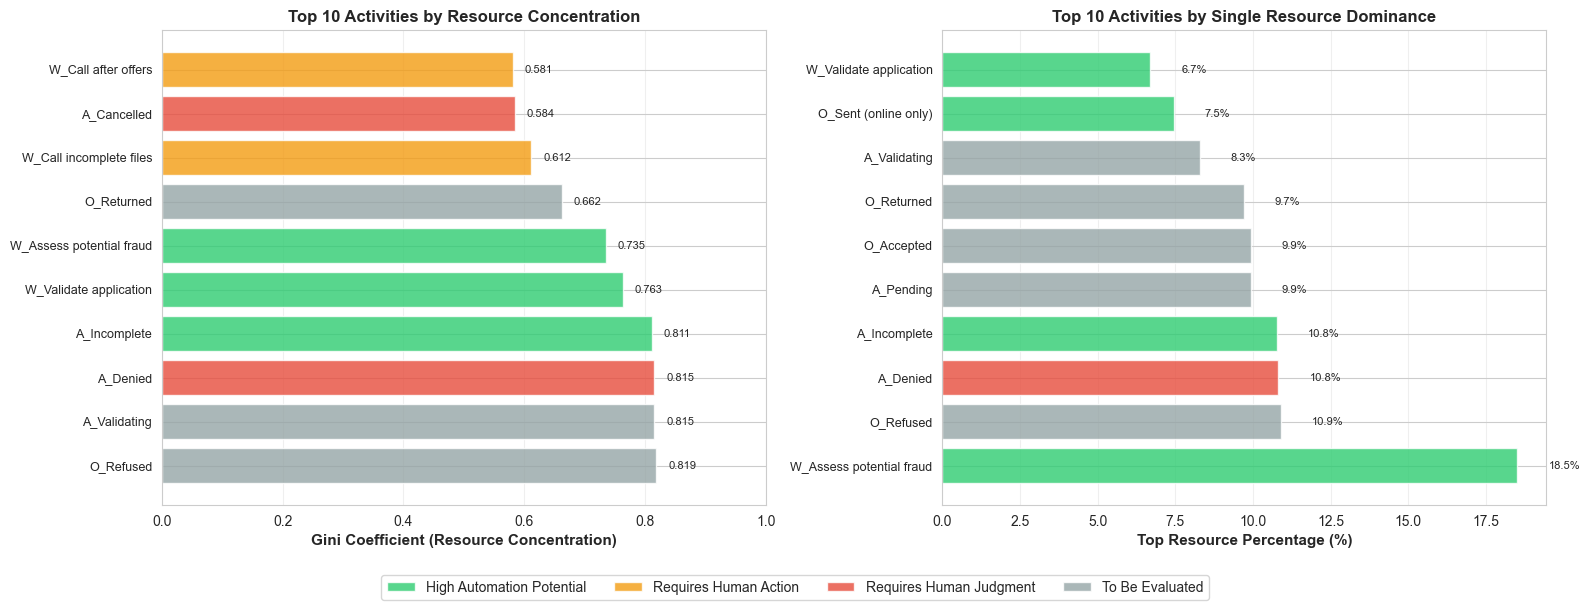


Activities with >80% single resource (likely already automated): 0


In [12]:
### PLOT 4: Resource Concentration Analysis

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Gini coefficient comparison
plot_data_gini = summary_df.sort_values('Gini_Coefficient', ascending=False).head(10)
colors_gini = [category_colors.get(cat, '#95a5a6') for cat in plot_data_gini['Automation_Category']]

bars1 = ax1.barh(range(len(plot_data_gini)), plot_data_gini['Gini_Coefficient'], 
                 color=colors_gini, alpha=0.8)
ax1.set_yticks(range(len(plot_data_gini)))
ax1.set_yticklabels(plot_data_gini['Activity'], fontsize=9)
ax1.set_xlabel('Gini Coefficient (Resource Concentration)', fontsize=11, fontweight='bold')
ax1.set_title('Top 10 Activities by Resource Concentration', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.set_xlim([0, 1])

# Add value labels
for i, val in enumerate(plot_data_gini['Gini_Coefficient']):
    ax1.text(val + 0.02, i, f"{val:.3f}", va='center', fontsize=8)

# Right plot: Top resource percentage
plot_data_top = summary_df.sort_values('Top_1_Resource_Pct', ascending=False).head(10)
colors_top = [category_colors.get(cat, '#95a5a6') for cat in plot_data_top['Automation_Category']]

bars2 = ax2.barh(range(len(plot_data_top)), plot_data_top['Top_1_Resource_Pct'], 
                 color=colors_top, alpha=0.8)
ax2.set_yticks(range(len(plot_data_top)))
ax2.set_yticklabels(plot_data_top['Activity'], fontsize=9)
ax2.set_xlabel('Top Resource Percentage (%)', fontsize=11, fontweight='bold')
ax2.set_title('Top 10 Activities by Single Resource Dominance', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for i, val in enumerate(plot_data_top['Top_1_Resource_Pct']):
    ax2.text(val + 1, i, f"{val:.1f}%", va='center', fontsize=8)

# Add single legend for automation categories (shared between both plots)
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=cat, alpha=0.8) 
                   for cat, color in category_colors.items() 
                   if cat in summary_df['Automation_Category'].values]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, fontsize=10, 
           bbox_to_anchor=(0.5, -0.02))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for the legend
plt.show()

print(f"\nActivities with >80% single resource (likely already automated): {len(summary_df[summary_df['Top_1_Resource_Pct'] > 80])}")

## Export Figures for Report

In [13]:
# Create figures directory
os.makedirs('figures', exist_ok=True)

# Set high DPI for publication-quality figures
plt.rcParams['figure.dpi'] = 300

print("Saving figures to 'figures/' directory...")

# Save Figure 1: Activity Frequency Distribution
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plot_data = summary_df.sort_values('Frequency', ascending=True)
colors = [category_colors.get(cat, '#95a5a6') for cat in plot_data['Automation_Category']]
bars = ax.barh(range(len(plot_data)), plot_data['Frequency'], color=colors, alpha=0.8)
ax.set_yticks(range(len(plot_data)))
ax.set_yticklabels(plot_data['Activity'], fontsize=9)
ax.set_xlabel('Frequency (number of occurrences)', fontsize=11, fontweight='bold')
ax.set_title('Activity Frequency by Automation Category', fontsize=13, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)
for i, (idx, row) in enumerate(plot_data.iterrows()):
    ax.text(row['Frequency'] + max(plot_data['Frequency'])*0.01, i, 
            f"{int(row['Frequency']):,}", va='center', fontsize=8)
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=cat, alpha=0.8) 
                   for cat, color in category_colors.items() 
                   if cat in plot_data['Automation_Category'].values]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)
plt.tight_layout()
plt.savefig('figures/activity_frequency_distribution.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: activity_frequency_distribution.png")

# Save Figure 4: Resource Concentration Analysis (with shared legend)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Gini coefficient comparison
plot_data_gini = summary_df.sort_values('Gini_Coefficient', ascending=False).head(10)
colors_gini = [category_colors.get(cat, '#95a5a6') for cat in plot_data_gini['Automation_Category']]
bars1 = ax1.barh(range(len(plot_data_gini)), plot_data_gini['Gini_Coefficient'], 
                 color=colors_gini, alpha=0.8)
ax1.set_yticks(range(len(plot_data_gini)))
ax1.set_yticklabels(plot_data_gini['Activity'], fontsize=9)
ax1.set_xlabel('Gini Coefficient (Resource Concentration)', fontsize=11, fontweight='bold')
ax1.set_title('Top 10 Activities by Resource Concentration', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.set_xlim([0, 1])

# Add value labels
for i, val in enumerate(plot_data_gini['Gini_Coefficient']):
    ax1.text(val + 0.02, i, f"{val:.3f}", va='center', fontsize=8)

# Right plot: Top resource percentage
plot_data_top = summary_df.sort_values('Top_1_Resource_Pct', ascending=False).head(10)
colors_top = [category_colors.get(cat, '#95a5a6') for cat in plot_data_top['Automation_Category']]
bars2 = ax2.barh(range(len(plot_data_top)), plot_data_top['Top_1_Resource_Pct'], 
                 color=colors_top, alpha=0.8)
ax2.set_yticks(range(len(plot_data_top)))
ax2.set_yticklabels(plot_data_top['Activity'], fontsize=9)
ax2.set_xlabel('Top Resource Percentage (%)', fontsize=11, fontweight='bold')
ax2.set_title('Top 10 Activities by Single Resource Dominance', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for i, val in enumerate(plot_data_top['Top_1_Resource_Pct']):
    ax2.text(val + 1, i, f"{val:.1f}%", va='center', fontsize=8)

# Add single legend for automation categories (shared between both plots)
legend_elements = [Patch(facecolor=color, label=cat, alpha=0.8) 
                   for cat, color in category_colors.items() 
                   if cat in summary_df['Automation_Category'].values]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, fontsize=10, 
           bbox_to_anchor=(0.5, -0.02))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for the legend
plt.savefig('figures/resource_concentration_analysis.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: resource_concentration_analysis.png")

print("\n✅ All figures saved successfully in 'figures/' directory!")
print("Ready for LaTeX report compilation.")

Saving figures to 'figures/' directory...
✓ Saved: activity_frequency_distribution.png
✓ Saved: resource_concentration_analysis.png

✅ All figures saved successfully in 'figures/' directory!
Ready for LaTeX report compilation.
